In [ ]:
!pip install piq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import required libraries
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from piq import ssim


In [ ]:
#class for data preprocessing
class EmotionImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.emotions = []

        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.PNG')

        for emotion_label in os.listdir(root_dir):
            emotion_dir = os.path.join(root_dir, emotion_label)
            if emotion_label == "Ahegao":
              continue
            if not os.path.isdir(emotion_dir):
                continue  # skip non-folder entries

            for img_name in os.listdir(emotion_dir):
                if img_name.endswith(valid_extensions):
                    full_path = os.path.join(emotion_dir, img_name)
                    self.image_paths.append(full_path)
                    self.emotions.append(emotion_label)

        from sklearn.preprocessing import LabelEncoder
        self.label_encoder = LabelEncoder()
        self.encoded_emotions = self.label_encoder.fit_transform(self.emotions)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
        except Exception as e:
            print(f"Skipping file {self.image_paths[idx]} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # fallback

        if self.transform:
            image = self.transform(image)

        label = self.encoded_emotions[idx]
        return label, image


In [ ]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter

#define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),             #resize to 64x64
    transforms.ToTensor(),                   #convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3),  #normalize to [-1, 1]
])

#dataset object
dataset = EmotionImageDataset(
    root_dir='/content/drive/MyDrive/archive-4/images',
    transform=transform
)


#Count samples per class
class_counts = Counter(dataset.encoded_emotions)
num_samples = len(dataset)

#Compute class weights
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in dataset.encoded_emotions]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

#Use sampler in DataLoader
dataloader = DataLoader(dataset, batch_size=64, sampler=sampler)



In [ ]:
#check number of samples
print("Number of samples:", len(dataset))

Number of samples: 2650


In [ ]:
#print the emotion classes and the total
num_emotions=len(dataset.label_encoder.classes_)
print("Emotion Classes:", dataset.label_encoder.classes_,'\n Total emotions: ',num_emotions)

Emotion Classes: ['Angry' 'Happy' 'Neutral' 'Sad' 'Surprise'] 
 Total emotions:  5


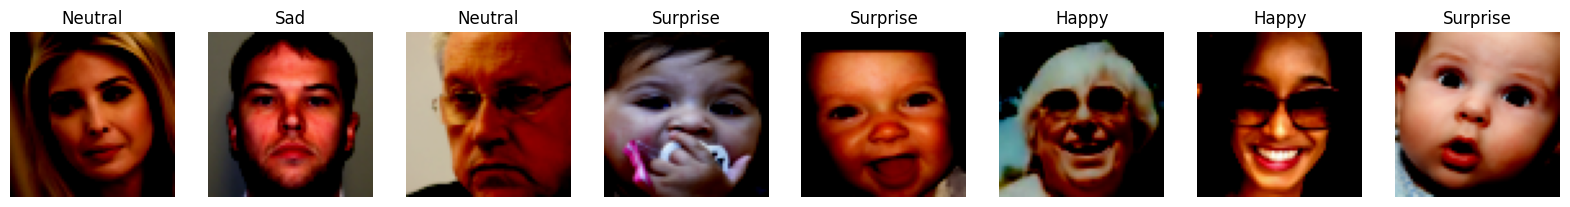

In [ ]:
#visualize some sample images with their emotions
emotion_batch, image_batch = next(iter(dataloader))

num_samples=8

plt.figure(figsize=(20, 5))
for i in range(num_samples):
    img = image_batch[i].permute(1, 2, 0).cpu().numpy()
    label = emotion_batch[i].item()
    class_name = dataset.label_encoder.classes_[label]

    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.show()

In [ ]:
import torch
import torch.nn as nn
#build encoder (CNN)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1), #112x112
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), #56x56
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),#28x28
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), #(batch, 128, 1, 1)
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [ ]:
#reparaterization trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [ ]:
#decoder (ViT)
class ViTStyleDecoder(nn.Module):
    def __init__(self, latent_dim, num_emotions, patch_dim=16, img_size=64):
        super(ViTStyleDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_emotions = num_emotions
        self.patch_dim = patch_dim
        self.img_size = img_size
        self.num_patches = (img_size // patch_dim) ** 2
        self.embedding_dim = 256

        #Project the latent vector + emotion vector into token embeddings
        self.project = nn.Linear(latent_dim + num_emotions, self.embedding_dim)

        #Learnable positional embeddings for the patches
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, self.embedding_dim))

        #Decoder part: Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=self.embedding_dim, nhead=8)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=4)

        #Final layer to map to pixel values (64x64 image)
        self.to_patches = nn.Linear(self.embedding_dim, patch_dim * patch_dim * 3)

    def forward(self, z_cond):
        batch_size = z_cond.size(0)

        #Project z_cond to token embeddings
        x = self.project(z_cond).unsqueeze(1)  #(B, 1, embed_dim)
        x = x.repeat(1, self.num_patches, 1)   #(B, num_patches, embed_dim)

        #Add positional encoding
        x = x + self.pos_embedding  #(B, num_patches, embed_dim)

        #Transformer decoder block
        x = self.transformer_decoder(x, x)  #(B, num_patches, embed_dim)

        #Map tokens to patches and reshape them to 2D
        x = self.to_patches(x)  #(B, num_patches, patch_dim*patch_dim*3)
        x = x.view(batch_size, self.img_size // self.patch_dim, self.img_size // self.patch_dim, self.patch_dim, self.patch_dim, 3)
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.view(batch_size, 3, self.img_size, self.img_size)  #(B, 3, 64, 64)
        return torch.tanh(x)


In [ ]:
#enhancing the resolution of the image (CNN)
class SuperResolutionHead(nn.Module):
    def __init__(self):
        super(SuperResolutionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
#defining the model, optimizer and their args
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 512
encoder = Encoder(latent_dim).to(device)
decoder = ViTStyleDecoder(latent_dim, num_emotions).to(device)
sr_head = SuperResolutionHead().to(device)
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) + list(sr_head.parameters()),
    lr=1e-4)

In [ ]:
from torchvision.models import vgg16
#perceptual loss fn (pretrained VGG16)
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(pretrained=True).features.eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = nn.Sequential(*list(vgg.children())[:16])
        self.criterion = nn.L1Loss()

    def forward(self, input, target):
        input_features = self.vgg(input)
        target_features = self.vgg(target)
        return self.criterion(input_features, target_features)


perceptual_loss_fn = VGGPerceptualLoss().to(device)
recon_loss_fn = nn.L1Loss()

#Training loop
epochs = 60
for epoch in range(epochs):
    total_loss = 0
    encoder.train()
    decoder.train()
    sr_head.train()

    for emotion_labels, images in dataloader:
        images = images.to(device)
        emotion_labels = emotion_labels.to(device)

        #Reparameterize
        mu, logvar = encoder(images)
        z = reparameterize(mu, logvar)

        #One hot emotion condition
        emotion_one_hot = F.one_hot(emotion_labels, num_classes=num_emotions).float().to(device)
        z_cond = torch.cat([z, emotion_one_hot], dim=1)

        #Decode + refine
        output = decoder(z_cond)
        refined = sr_head(output)

        #Rescale to [0, 1] for perceptual loss (from Tanh [-1, 1])
        recon_vgg = (refined + 1) / 2
        images_vgg = (images + 1) / 2

        #Compute individual losses
        recon_loss = recon_loss_fn(refined, images)
        perc_loss = perceptual_loss_fn(recon_vgg, images_vgg)
        ssim_loss = 1 - ssim(recon_vgg, images_vgg, data_range=1.)  # SSIM ranges from 0 to 1

        #Combine
        loss = recon_loss + 0.2 * perc_loss + 0.2 * ssim_loss

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(dataloader):.4f}")


In [ ]:
#Bring the model back, to contiue ttraining
encoder.load_state_dict(torch.load("/content/drive/MyDrive/emotion_model_v2/encoder.pth"))
decoder.load_state_dict(torch.load("/content/drive/MyDrive/emotion_model_v2/decoder.pth"))
sr_head.load_state_dict(torch.load("/content/drive/MyDrive/emotion_model_v2/sr_head.pth"))


<All keys matched successfully>

In [ ]:
#initializing the optimizer for the 3 networks (after the 60 epochs)
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) + list(sr_head.parameters()),
    lr=1e-5
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
#Continue Training after the 60th epoch
for epoch in range(60, 90):
    total_loss = 0
    encoder.train()
    decoder.train()
    sr_head.train()

    for emotion_labels, images in dataloader:
        images = images.to(device)
        emotion_labels = emotion_labels.to(device)

        #Reparameterize
        mu, logvar = encoder(images)
        z = reparameterize(mu, logvar)

        #One hot emotion condition
        emotion_one_hot = F.one_hot(emotion_labels, num_classes=num_emotions).float().to(device)
        z_cond = torch.cat([z, emotion_one_hot], dim=1)

        #Decode + refine
        output = decoder(z_cond)
        refined = sr_head(output)

        #Rescale to [0, 1] for perceptual loss (from Tanh [-1, 1])
        recon_vgg = (refined + 1) / 2
        images_vgg = (images + 1) / 2

        #Compute individual losses
        recon_loss = recon_loss_fn(refined, images)
        perc_loss = perceptual_loss_fn(recon_vgg, images_vgg)
        ssim_loss = 1 - ssim(recon_vgg, images_vgg, data_range=1.)  #SSIM ranges from 0 to 1

        #Combine
        loss = recon_loss + 0.2 * perc_loss + 0.2 * ssim_loss

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/90] Loss: {total_loss/len(dataloader):.4f}")
#Training here was interrupted because there was no signinficant reduction in the loss

Epoch [61/90] Loss: 0.3920
Epoch [62/90] Loss: 0.3900
Epoch [63/90] Loss: 0.3958
Epoch [64/90] Loss: 0.3920
Epoch [65/90] Loss: 0.3891
Epoch [66/90] Loss: 0.3902
Epoch [67/90] Loss: 0.3893
Epoch [68/90] Loss: 0.3941
Epoch [69/90] Loss: 0.3904
Epoch [70/90] Loss: 0.3856
Epoch [71/90] Loss: 0.3846
Epoch [72/90] Loss: 0.3956
Epoch [73/90] Loss: 0.3841
Epoch [74/90] Loss: 0.3848
Epoch [75/90] Loss: 0.3877
Epoch [76/90] Loss: 0.3895
Epoch [77/90] Loss: 0.3904
Epoch [78/90] Loss: 0.3899


KeyboardInterrupt: 

In [ ]:
#Testing
encoder.eval()
decoder.eval()
sr_head.eval()

with torch.no_grad():
    emotion_labels, images = next(iter(dataloader))
    images = images.to(device)
    emotion_labels = emotion_labels.to(device)

    #Encode + sample
    mu, logvar = encoder(images)
    z = reparameterize(mu, logvar)

    #One hot emotion condition
    emotion_one_hot = F.one_hot(emotion_labels, num_classes=num_emotions).float().to(device)
    z_cond = torch.cat([z, emotion_one_hot], dim=1)

    #Decode and enhance
    output = decoder(z_cond)
    reconstructed_images = sr_head(output)

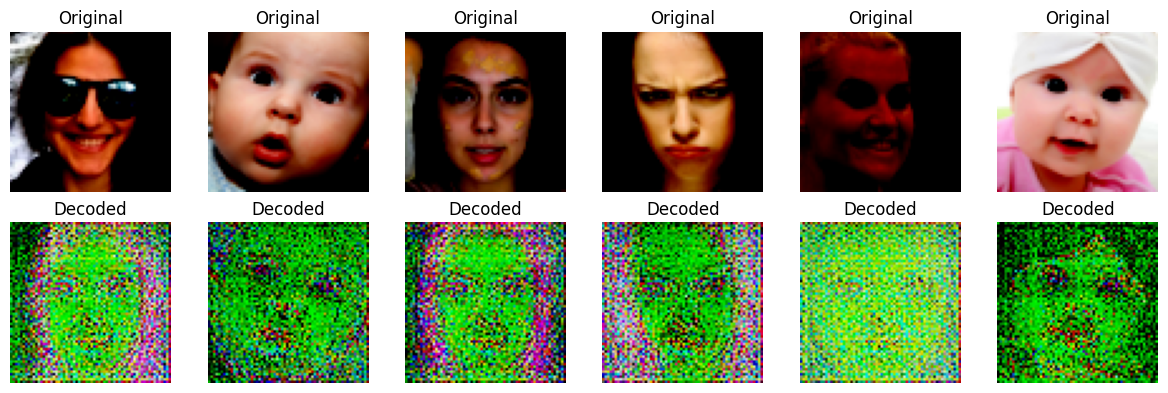

In [ ]:
#Showing the results without the high resolution head
encoder.eval()
decoder.eval()

with torch.no_grad():
    emotion_labels, images = next(iter(dataloader))
    images = images.to(device)
    emotion_labels = emotion_labels.to(device)

    #Encode + sample
    mu, logvar = encoder(images)
    z = reparameterize(mu, logvar)

    #One hot emotion condition
    emotion_one_hot = F.one_hot(emotion_labels, num_classes=num_emotions).float().to(device)
    z_cond = torch.cat([z, emotion_one_hot], dim=1)

    #Decode only (no sr_head)
    reconstructed_images = decoder(z_cond)

#Visualize original and reconstructed images
import matplotlib.pyplot as plt

#Move to CPU and detach
orig = images.cpu()
recon = reconstructed_images.cpu()

#Show a few samples
n = 6
plt.figure(figsize=(12, 4))
for i in range(n):
    #Original
    plt.subplot(2, n, i + 1)
    plt.imshow(orig[i].permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis("off")
    plt.title("Original")

    #Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis("off")
    plt.title("Decoded")

plt.tight_layout()
plt.show()


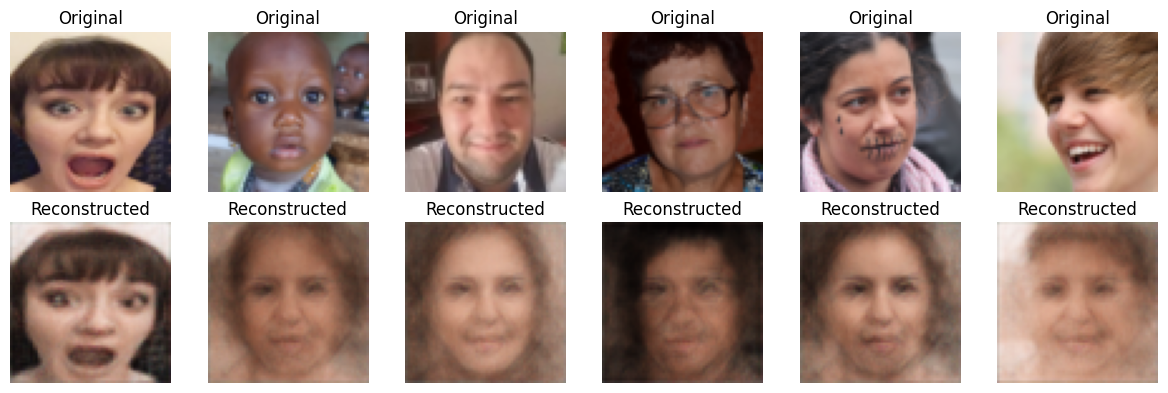

In [ ]:
#Shoing the results with the High-Resolutoin Head
num_show = 6
plt.figure(figsize=(12, 4))

for i in range(num_show):
    #original
    plt.subplot(2, num_show, i+1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow((img * 0.5 + 0.5).clip(0, 1))  #assuming normalization
    plt.title("Original")
    plt.axis('off')

    #reconstructed
    plt.subplot(2, num_show, num_show + i + 1)
    recon = reconstructed_images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow((recon * 0.5 + 0.5).clip(0, 1)) #scaled from Tanh
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Save the model + the optimizer
save_path = "/content/drive/MyDrive/emotion_model_v2"
!mkdir -p "$save_path"

torch.save(encoder.state_dict(), f"{save_path}/encoder77.pth")
torch.save(decoder.state_dict(), f"{save_path}/decoder77.pth")
torch.save(sr_head.state_dict(), f"{save_path}/sr_head77.pth")
torch.save(optimizer.state_dict(), f"{save_path}/optimizer77.pth")
